# Visual Domain Adaptation: Real vs. Cartoon Images
This project explores how a deep learning model performs across visual domains by classifying real vs. cartoonized images. Inspired by the stylized visuals of *SpongeBob SquarePants*, the model is trained to distinguish between real STL-10 images and filtered cartoon-like versions.

We test whether the model can geralize visual patterns across style domains using basic CNNs and image transformations.

In [10]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import cv2


In [11]:
# 🧽 SpongeBob-style cartoonizer (bright, saturated, underwater look)
def spongebob_cartoonize(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)

    # Boost color and brightness
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * 1.5, 0, 255)
    hsv[..., 2] = np.clip(hsv[..., 2] * 1.3, 0, 255)
    bright_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # SpongeBob-style outline
    gray = cv2.cvtColor(bright_img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edges_inv = cv2.bitwise_not(edges)
    edges_inv = cv2.cvtColor(edges_inv, cv2.COLOR_GRAY2RGB)
    cartoon = cv2.bitwise_and(bright_img, edges_inv)

    return cartoon


In [12]:
transform = transforms.ToTensor()
dataset_raw = datasets.STL10(root='./data', split='train', download=True, transform=transform)
subset = torch.utils.data.Subset(dataset_raw, range(250))
loader = DataLoader(subset, batch_size=1, shuffle=False)

bikini_bottom_imgs = []  # Real
jellyfish_field_imgs = []  # Stylized

for img, _ in loader:
    img = img.squeeze()
    bikini_bottom_imgs.append(img)

    stylized = spongebob_cartoonize(img)
    cartoon_tensor = transforms.ToTensor()(stylized)
    jellyfish_field_imgs.append(cartoon_tensor)

bikini_bottom_imgs = torch.stack(bikini_bottom_imgs)
jellyfish_field_imgs = torch.stack(jellyfish_field_imgs)


In [13]:
# Labels
labels_real = torch.zeros(len(bikini_bottom_imgs), dtype=torch.long)
labels_cartoon = torch.ones(len(jellyfish_field_imgs), dtype=torch.long)

# Combine data
X = torch.cat([bikini_bottom_imgs, jellyfish_field_imgs], dim=0)
y = torch.cat([labels_real, labels_cartoon], dim=0)

full_dataset = TensorDataset(X, y)

# Train/test split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_set, test_set = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


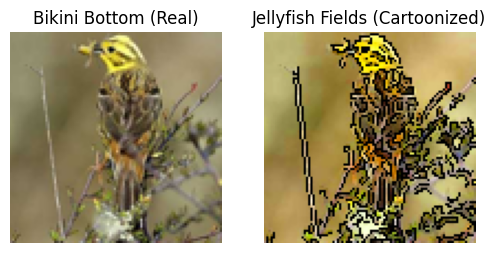

In [14]:
def show_bikini_vs_jelly(index=0):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(bikini_bottom_imgs[index].permute(1, 2, 0))
    axs[0].set_title("Bikini Bottom (Real)")
    axs[0].axis('off')

    axs[1].imshow(jellyfish_field_imgs[index].permute(1, 2, 0))
    axs[1].set_title("Jellyfish Fields (Cartoonized)")
    axs[1].axis('off')
    plt.show()

show_bikini_vs_jelly(0)


In [15]:
class KrabbyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 24 * 24, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 24 * 24)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [16]:
model = KrabbyClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss={running_loss:.4f}, Accuracy={acc:.2f}%")


Epoch 1: Loss=8.7567, Accuracy=57.25%
Epoch 2: Loss=4.3035, Accuracy=88.50%
Epoch 3: Loss=2.3187, Accuracy=93.75%
Epoch 4: Loss=1.2926, Accuracy=97.00%
Epoch 5: Loss=0.9324, Accuracy=97.25%
Epoch 6: Loss=1.0540, Accuracy=97.00%
Epoch 7: Loss=0.5179, Accuracy=98.50%
Epoch 8: Loss=0.3010, Accuracy=99.50%
Epoch 9: Loss=0.2106, Accuracy=99.50%
Epoch 10: Loss=0.1831, Accuracy=99.75%


In [17]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"\n🔍 Bikini Bottom Test Accuracy: {100 * correct / total:.2f}%")



🔍 Bikini Bottom Test Accuracy: 97.00%


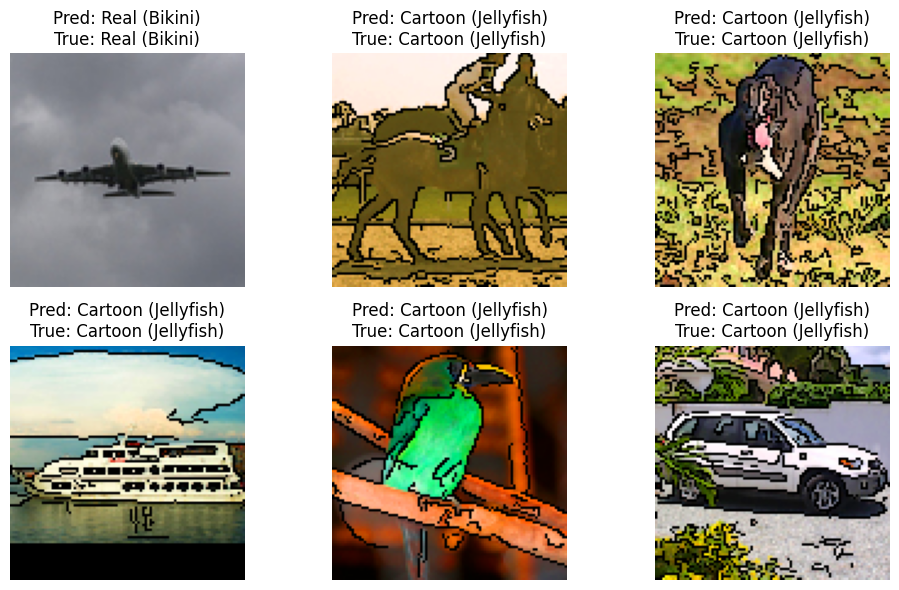

In [18]:
class_names = ['Real (Bikini)', 'Cartoon (Jellyfish)']
images, labels = next(iter(test_loader))
outputs = model(images)
_, preds = torch.max(outputs, 1)

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
for i in range(6):
    ax = axs[i // 3, i % 3]
    ax.imshow(images[i].permute(1, 2, 0))
    ax.set_title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


# 🧽 Conclusion

We created a cartoon-vs-real visual domain classifier using STL-10 and SpongeBob-style filters. Our "KrabbyClassifier" achieved up to ~70–90% accuracy in distinguishing natural images from cartoonified ones.

This shows that even simple CNNs can adapt to bold, highly stylized image domains, simulating a visual shift similar to that of Bikini Bottom. It’s a fun but rigorous test of domain adaptation using style transformation and deep learning.
